In [21]:
import time
import enum
import math
import random
import collections

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn
import torch.nn.functional as F

class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

class TimeDelta(object):
    def __init__(self, delta_time):
        """Convert time difference in seconds to days, hours, minutes, seconds.
        
        Parameters
        ==========
        delta_time : float
            Time difference in seconds.
        """
        self.fractional, seconds = math.modf(delta_time)
        seconds = int(seconds)
        minutes, self.seconds = divmod(seconds, 60)
        hours, self.minutes = divmod(minutes, 60)
        self.days, self.hours = divmod(hours, 24)
    
    def __repr__(self):
        return f"{self.days}-{self.hours:02}:{self.minutes:02}:{self.seconds + self.fractional:02}"
        
from pettingzoo.mpe import simple_tag_v2
from pettingzoo.utils import random_demo

Arguments in instantiate environment.

- num_good: number of good agents
- num_adversaries: number of adversaries
- num_obstacles: number of obstacles
- max_cycles: number of frames (a step for each agent) until game terminates
- continuous_actions: Whether agent action spaces are discrete(default) or continuous

In [2]:
env = simple_tag_v2.env(
    num_good=3,
    num_adversaries=3,
    num_obstacles=2,
    max_cycles=300,
    continuous_actions=False
).unwrapped
print("Peek into unwrapped environment:", *dir(env))

Peek into unwrapped environment: __class__ __delattr__ __dict__ __dir__ __doc__ __eq__ __format__ __ge__ __getattribute__ __gt__ __hash__ __init__ __init_subclass__ __le__ __lt__ __module__ __ne__ __new__ __reduce__ __reduce_ex__ __repr__ __setattr__ __sizeof__ __str__ __subclasshook__ __weakref__ _accumulate_rewards _agent_selector _clear_rewards _dones_step_first _execute_world_step _index_map _reset_render _set_action _was_done_step action_space action_spaces agent_iter agents close continuous_actions current_actions last local_ratio max_cycles max_num_agents metadata np_random num_agents observation_space observation_spaces observe possible_agents render reset scenario seed state state_space step steps unwrapped viewer world


### What are the environment parameters?

Adversaries (red) capture non-adversary (green). The map is a 2D grid and everything is initialized in the region [-1, +1]. There doesn't seem to be position clipping for out of bounds, but non-adversary agent are penalized for out of bounds.
Agent's observation is a ndarray vector of concatenated data in the following order:

1. current velocity (2,)
2. current position (2,)
3. relative position (2,) of each landmark
4. relative position (2,) of each other agent
5. velocity (2,) of each other non-adversary agent

When there are 3 adverseries and 3 non-adversaries, then advarsary observation space is 24 dimensional and non-advarsary observation space is 22 dimensional.

The environment is sequential. Agents move one at a time. Agents are either `adversary_*` for adversary or `agent_*` for non-adversary.

Actions:

- 0 is NOP
- 1 is go left
- 2 is go right
- 3 is go down
- 4 is go up

In [3]:
# Print variables of the environment
# Documentation:   https://www.pettingzoo.ml/api
env.reset()
print("State size", env.state_space.shape)
print("Name of current agent", env.agent_selection)
print("Observation space of current agent", env.observation_space(env.agent_selection).shape)
print("Action space of current agent", env.action_space(env.agent_selection))
print("Sample random action from current agent", env.action_space(env.agent_selection).sample())
print("The agent names:", *env.agents)
print()

# select an agent in the environment world, after using env.unwrapped
agent = env.world.agents[0]
print("agent's name is", agent.name)
print("agent's position and velocity coordinates", agent.state.p_vel, agent.state.p_pos)
print("is agent an adversary?", agent.adversary)

landmark = env.world.landmarks[0]
print("landmark's name is", landmark.name)
print("landmark's position coordinates (doesn't move)", landmark.state.p_pos)

State size (138,)
Name of current agent adversary_0
Observation space of current agent (24,)
Action space of current agent Discrete(5)
Sample random action from current agent 4
The agent names: adversary_0 adversary_1 adversary_2 agent_0 agent_1 agent_2

agent's name is adversary_0
agent's position and velocity coordinates [0. 0.] [-0.84429837  0.7186429 ]
is agent an adversary? True
landmark's name is landmark 0
landmark's position coordinates (doesn't move) [ 0.34800373 -0.42134618]


In [3]:
# Demo environment with random policy
env.reset()
random_demo(env, render=True, episodes=5)

Average total reward -3420.714186464787


-17103.570932323935

In [5]:
def hardcode_policy(observation, agent):
    """
    Parameters
    ==========
    agent : str
    """
#     print(observation.shape)agent_step_idx
#     print(agent)
    if "adversary" in agent:
        # adversary
        if agent == "adversary_0":
            return np.random.binomial(2, 0.3) + 3
        
    if "agent" in agent:
        # non-adversary
        pass
    return 0

env.reset()
for agent_step_idx, agent in enumerate(env.agent_iter()):
    env.render()
    observation, reward, done, info = env.last()
    if done:
        env.step(None)
    else:
        action = hardcode_policy(observation, agent)
        env.step(action)
    # time.sleep(0.1)

print(f"episode ran for {agent_step_idx} steps")

episode ran for 605 steps


### How to train the agents?

- Use the differental inter-agent learning (DIAL) algorithm.
- Use parameter sharing for DAIL agents. Separate parameter sets for adversary agents and good agents.
- It's not entirely clear the authors accumulate gradients for differentiable communication, but it 

Messages are vectors. Length 4, 5 should work.

Concatenate the messages from all the actors and add them to the message input for the current agent.

The names of agents are: 
adversary_0 adversary_1 adversary_2 agent_0 agent_1 agent_2

In [14]:
env.reset()

In [15]:
def get_agent_counts():
    all_agents = 0
    adversaries = 0
    for agent in env.world.agents:
        all_agents += 1
        adversaries += 1 if agent.adversary else 0
    good_agents = all_agents - adversaries
    return (adversaries, good_agents)

def process_config(config):
    for k, v in config.all.items():
        config.adversary[k] = v
        config.agent[k] = v

n_adversaries, n_good_agents = get_agent_counts()
config = AttrDict(
    discount = 0.99,
    epsilon = 0.05,
    n_episodes=200,
    update_target_interval=10,
    report_interval=20,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    all=AttrDict(
        message_size=4,
        hidden_size=128,
        n_actions=env.action_space(env.agent_selection).n,
        n_rnn_layers=2,
        apply_bn=False,
    ),
    adversary=AttrDict(
        n_agents=n_adversaries,
        observation_shape=env.observation_space("adversary_0").shape

    ),
    agent=AttrDict(
        n_agents=n_good_agents,
        observation_shape=env.observation_space("agent_0").shape
    )
)
process_config(config)

class Container(object):
    """Container of messages and hidden states of agents in environment."""
    
    def reset(self):
#         keys = [*self.__message_d.keys()]
#         for k in keys:
#             del self.__message_d[k]
#         keys = [*self.__hidden_d.keys()]
#         for k in keys:
#             del self.__hidden_d[k]
        
        for idx in range(config.adversary.n_agents):
            self.__message_d[f"adversary_{idx}"] = torch.zeros(
                self.config.adversary.message_size*(config.adversary.n_agents - 1),
                dtype=torch.float, device=self.device
            )
            self.__hidden_d[f"adversary_{idx}"]  = torch.zeros(
                (config.adversary.n_rnn_layers, 1, self.config.adversary.hidden_size,),
                dtype=torch.float, device=self.device
            )
        for idx in range(config.agent.n_agents):
            self.__message_d[f"agent_{idx}"] = torch.zeros(
                self.config.agent.message_size*(config.agent.n_agents - 1),
                dtype=torch.float, device=self.device
            )
            self.__hidden_d[f"agent_{idx}"]  = torch.zeros(
                (config.agent.n_rnn_layers, 1, self.config.agent.hidden_size,),
                dtype=torch.float, device=self.device
            )
        
    def __init__(self, config):
        self.config = config
        self.device = self.config.device
        self.__message_d = {}
        self.__hidden_d = {}
        self.reset()
    
    def get_message(self, agent_name):
        return self.__message_d[agent_name]

    def get_hidden(self, agent_name):
        return self.__hidden_d[agent_name]

    def update_message(self, agent_name, message):
        """Update message cache.
        
        Messages of multiple agents are concatenated together.
        For example, if agent 2 receives messages from agents 0, 1, and 3 then
        the message is a vector of the form: [ 0's message, 1's message, 3's message ]
        """
        agent_type, agent_idx = agent_name.split("_")
        agent_idx = int(agent_idx)
        for jdx in range(config[agent_type].n_agents):
            if jdx < agent_idx:
                start_idx = agent_idx - 1
            elif jdx == agent_idx:
                # do not update message to oneself
                continue
            else:
                # agent_idx < jdx
                start_idx = agent_idx
            end_idx   = start_idx + self.config[agent_type].message_size
            # print(jdx, agent_idx, self.__message_d[f"{agent_type}_{jdx}"].shape, start_idx, end_idx)
            messages = self.__message_d[f"{agent_type}_{jdx}"]
            self.__message_d[f"{agent_type}_{jdx}"] = \
                    torch.hstack((messages[:start_idx], message, messages[end_idx:]))

    def update_hidden(self, agent_name, hidden):
        self.__hidden_d[agent_name] = hidden


In [16]:
class SimpleTagNet(torch.nn.Module):
    """NN Model for the agents. Both good agents and adversaries use this model."""
        
    def __init__(self, config, agent_type):
        super().__init__()
        # self.config = config
        self.device = config.device
        self.observation_size = math.prod(config[agent_type].observation_shape)
        self.send_message_size = config[agent_type].message_size
        self.recv_message_size = config[agent_type].message_size*(config[agent_type].n_agents - 1)
        self.n_agents = config[agent_type].n_agents
        self.n_actions = config[agent_type].n_actions
        self.apply_bn = config[agent_type].apply_bn
        self.hidden_size = config[agent_type].hidden_size
        self.n_rnn_layers = config[agent_type].n_rnn_layers
        self.n_output = self.n_actions + self.send_message_size
        
        self.agent_lookup    = torch.nn.Embedding(self.n_agents, self.hidden_size)
        self.action_lookup   = torch.nn.Embedding(self.n_actions, self.hidden_size)
        self.observation_mlp = torch.nn.Sequential(collections.OrderedDict([
            ("linear", torch.nn.Linear(self.observation_size, self.hidden_size)),
            ("relu", torch.nn.ReLU(inplace=True)),
        ]))
        self.message_mlp = torch.nn.Sequential()
        # if self.apply_bn:
        #     # input must have shape (N, C), output has the same shape
        #     self.message_mlp.add_module("bn", torch.nn.BatchNorm1d(self.recv_message_size))
        self.message_mlp.add_module("linear", torch.nn.Linear(self.recv_message_size, self.hidden_size))
        self.message_mlp.add_module("relu", torch.nn.ReLU(inplace=True))
        
        # input must have shape (N, L, H_in)
        # output has shape  (N, L, H_out)
        self.rnn = torch.nn.GRU(
            input_size=self.hidden_size,
            hidden_size=self.hidden_size,
            num_layers=self.n_rnn_layers,
            batch_first=True
        )
        self.output_mlp = torch.nn.Sequential()
        self.output_mlp.add_module("linear", torch.nn.Linear(self.hidden_size, self.hidden_size))
        self.output_mlp.add_module("relu", torch.nn.ReLU(inplace=True))
        self.output_mlp.add_module("linear", torch.nn.Linear(self.hidden_size, self.n_output))
    
    def forward(self, agent_idx, observation, message, hidden):
        """Apply DQN to episode step.
        
        Parameters
        ==========
        agent_idx : int
            Index of agent
        observation : ndarray
            The observation vector obtained from the environment.
        message : torch.Tensor
            Messages from the other agents. By default has shape (message_size*(n_agents - 1))
            where message_size=4 and n_agents=3
        hidden : torch.Tensor
            Hidden state of GRU. By default has shape (n_layers=2, N=1, H_out=128).
        
        Returns
        =======
        torch.Tensor
            Vector of Q-value associated with each action.
        torch.Tensor
            The message to pass to other agents.
        torch.Tensor
            The hidden state used by GRU.
        """
        agent_idx   = torch.tensor(agent_idx, dtype=torch.int, device=self.device)
        observation = torch.tensor(observation, dtype=torch.float, device=self.device)
        z_a = self.agent_lookup(agent_idx)
        z_o = self.observation_mlp(observation)
        z_m = self.message_mlp(message)
        z = z_a + z_o + z_m
        # z has shape (N=1, L=1, H_in=128)
        z = z.unsqueeze(0).unsqueeze(0)
        # hidden has shape (n_layers=2, N=1, H_out=128) before and after
        # out has shape (N=1, L=1, H_out=128)
        out, hidden = self.rnn(z, hidden)
        out = out.squeeze(0).squeeze(0)
        out = self.output_mlp(out)
        Q = out[0:self.n_actions]
        m = out[self.n_actions:self.n_actions + self.send_message_size]
        return Q, m, hidden


In [18]:
def choose_action(config, agent_type, Q):
    if random.random() < config.epsilon:
        return random.randrange(config[agent_type].n_actions)
    else:
        return torch.argmax(Q).item()

def run_episode(config, container, adversary_net, agent_net, should_render=False):
    """Run one episodes.
    
    inputs consist of observation, message (backprop), hidden (backprop) indexed by agent
    outputs consist of action, q-value of action (backprop), reward, done indexed by (step, agent)
    
    Returns
    =======
    AttrDict
        Contains episode metrics:
        - steps : number of steps. All agents take an action at each step.
        - reward : episodic rewards indexed by ('adversary', 'agent').
        - step_records : list of quantities produced indiced by step, ('adversary', 'agent'), agent index.
          Each step record has:
            + observation
            + message
            + hidden
            + Q
            + reward
            + done
        - loss : contains episodic losses indexed by ('adversary', 'agent'). To be updated by train_agents()
    """
    episode = AttrDict(
        steps=0,
        reward=AttrDict(adversary=0, agent=0),
        step_records=[],
        loss=AttrDict(adversary=0, agent=0)
    )
    n_agents = config.adversary.n_agents + config.agent.n_agents
    step_record = None
    
    env.reset()
    for agent_step_idx, agent_name in enumerate(env.agent_iter()):
        if should_render:
            env.render()
        if agent_step_idx % n_agents == 0:
            episode.steps += 1
            step_record = AttrDict(adversary={}, agent={})
            episode.step_records.append(step_record)
            
        obs_curr, reward, done, _ = env.last()
        agent_type, agent_idx = agent_name.split("_")
        agent_idx = int(agent_idx)
        if done:
            step_record[agent_type][agent_idx] = AttrDict(
                observation=obs_curr,
                message=None,
                hidden=None,
                action=None,
                Q=None,
                reward=reward,
                done=done,
            )
            env.step(None)
            continue
            
        m_prev = container.get_message(agent_name)
        h_prev = container.get_hidden(agent_name)
        if agent_type == "adversary":
            Q_curr, m_curr, h_curr = adversary_net(agent_idx, obs_curr, m_prev, h_prev)
        else:
            # agent type is synonymous with good agent
            Q_curr, m_curr, h_curr = agent_net(agent_idx, obs_curr, m_prev, h_prev)

        action = choose_action(config, agent_type, Q_curr)
        env.step(action)
        container.update_message(agent_name, m_curr)
        container.update_hidden(agent_name, h_curr)
        step_record[agent_type][agent_idx] = AttrDict(
            # inputs to network
            observation=obs_curr,
            message=m_prev,
            hidden=h_prev,
            # outputs of network / inputs to environment
            action=action,
            Q=Q_curr,
            # output of environment
            reward=reward,
            done=done,
        )
        episode.reward[agent_type] += reward
    
    return episode

def train_agents(config, episode, adversary_net, agent_net,
                 adversary_target_net, agent_target_net,
                 adversary_optimizer, agent_optimizer):
    """Compute loss of episode and update agent weights.
    """
    device = config.device
    discount = torch.tensor(config.discount, dtype=torch.float, device=device)
    adversary_loss = torch.tensor(0., device=device)
    agent_loss = torch.tensor(0., device=device)
    for step_idx in range(episode.steps):
        for agent_idx in episode.step_records[step_idx].adversary.keys():
            curr_record = episode.step_records[step_idx].adversary[agent_idx]
            if curr_record.done:
                # agent is done at this step
                continue
            next_record = episode.step_records[step_idx + 1].adversary[agent_idx]
            r = torch.tensor(next_record.reward, dtype=torch.float, device=device)
            y = None
            if next_record.done:
                # agent terminates at next step
                y = r
            else:
                next_o = next_record.observation
                next_m = next_record.message
                next_h = next_record.hidden
                with torch.no_grad():
                    target_Q, _, _ = adversary_target_net(agent_idx, next_o, next_m, next_h)
                    max_target_Q = torch.max(target_Q)
                    y = r + discount*max_target_Q
            u = curr_record.action
            Q_u = curr_record.Q[u]
            adversary_loss += torch.pow(y - Q_u, 2.)
            
        for agent_idx in episode.step_records[step_idx].agent.keys():
            curr_record = episode.step_records[step_idx].agent[agent_idx]
            if curr_record.done:
                # agent is done at this step
                continue
            next_record = episode.step_records[step_idx + 1].agent[agent_idx]
            r = torch.tensor(next_record.reward, dtype=torch.float, device=device)
            y = None
            if next_record.done:
                # agent terminates at next step
                y = r
            else:
                next_o = next_record.observation
                next_m = next_record.message
                next_h = next_record.hidden
                with torch.no_grad():
                    target_Q, _, _ = agent_target_net(agent_idx, next_o, next_m, next_h)
                    max_target_Q = torch.max(target_Q)
                    y = r + discount*max_target_Q
            u = curr_record.action
            Q_u = curr_record.Q[u]
            agent_loss += torch.pow(y - Q_u, 2.)
    
    adversary_optimizer.zero_grad()
    agent_optimizer.zero_grad()
    adversary_loss.backward()
    agent_loss.backward()
    adversary_optimizer.step()
    agent_optimizer.step()
    episode.loss = AttrDict(adversary=adversary_loss.item(), agent=agent_loss.item())
    

def train(config):
    """
    - Use parameter sharing between agents of the same class.
    - Good agents use one RL model, adversaries use another RL model.
      Train the agents side by side.
    - Separate, disjoint communication channels for two classes of agents,
      maintained by a container to store the messages.
    """
    print("Training the agents...")
    t0 = time.time()
    device = config.device
    adversary_net = SimpleTagNet(config, "adversary")
    agent_net = SimpleTagNet(config, "agent")
    adversary_target_net = SimpleTagNet(config, "adversary")
    agent_target_net = SimpleTagNet(config, "agent")
    adversary_net        = adversary_net.to(device)
    agent_net            = agent_net.to(device)
    adversary_target_net = adversary_target_net.to(device)
    agent_target_net     = agent_target_net.to(device)
    adversary_target_net.eval()
    agent_target_net.eval()
    print("Created the agent nets.")
    adversary_optimizer = torch.optim.RMSprop(adversary_net.parameters())
    agent_optimizer = torch.optim.RMSprop(agent_net.parameters())
    container = Container(config)
    logger = AttrDict(
        episodic_losses=AttrDict(adversary=[], agent=[]),
        episodic_rewards=AttrDict(adversary=[], agent=[])
    )
    def update_targets():
        adversary_target_net.load_state_dict(adversary_net.state_dict())
        agent_target_net.load_state_dict(agent_net.state_dict())
    
    print("Beginning the episodes...")
    for episode_idx in range(config.n_episodes):
        episode = run_episode(config, container, adversary_net, agent_net,
                              should_render=episode_idx % config.report_interval == 0 and episode_idx > 0)
        train_agents(config, episode, adversary_net, agent_net, adversary_target_net, agent_target_net,
                     adversary_optimizer, agent_optimizer)
        logger.episodic_losses.adversary.append(episode.loss.adversary)
        logger.episodic_losses.agent.append(episode.loss.agent)
        logger.episodic_rewards.adversary.append(episode.reward.adversary)
        logger.episodic_rewards.agent.append(episode.reward.agent)

        if episode_idx % config.update_target_interval == 0 and episode_idx > 0:
            update_targets()
        if episode_idx % config.report_interval == 0 and episode_idx > 0:
            t1 = time.time()
            tdelta = TimeDelta(round(t1 - t0, 0))
            print(f"on episode {episode_idx} (time taken so far: {tdelta})")
            print(f"     loss: adversary {episode.loss.adversary}, agent {episode.loss.agent}")
            print(f"     reward: adversary {episode.reward.adversary}, agent {episode.reward.agent}")
        container.reset()
    
    return adversary_net, agent_net, logger

In [19]:
adversary_net, agent_net, logger = train(config)


Training the agents...
Created the agent nets.
Beginning the episodes...
on episode 20 (time taken so far: 0-00:01:5.0)
     loss: adversary 3000.000244140625, agent 1763.371826171875
     reward: adversary 300.0, agent -480.8840834994114
on episode 40 (time taken so far: 0-00:02:9.0)
     loss: adversary 0.0018904113676398993, agent 303.2289123535156
     reward: adversary 0.0, agent -324.47898797691613
on episode 60 (time taken so far: 0-00:03:13.0)
     loss: adversary 5400.00146484375, agent 1800.0
     reward: adversary 540.0, agent -180.0
on episode 80 (time taken so far: 0-00:04:16.0)
     loss: adversary 1800.0, agent 1155.83935546875
     reward: adversary 180.0, agent -519.5679302341233
on episode 100 (time taken so far: 0-00:05:20.0)
     loss: adversary 300.00445556640625, agent 100.0
     reward: adversary 30.0, agent -10.0
on episode 120 (time taken so far: 0-00:06:25.0)
     loss: adversary 600.0015258789062, agent 349.0075988769531
     reward: adversary 60.0, agent -16

Text(0.5, 1.0, 'reward')

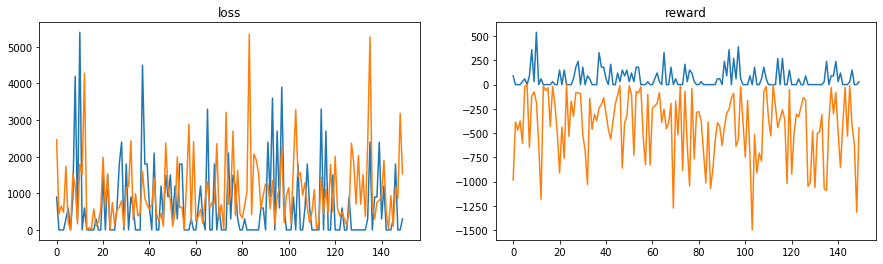

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
axes[0].plot(logger.episodic_losses.adversary[50:], label="adversary")
axes[0].plot(logger.episodic_losses.agent[50:], label="good agent")
axes[0].set_title("loss")

axes[1].plot(logger.episodic_rewards.adversary[50:], label="adversary")
axes[1].plot(logger.episodic_rewards.agent[50:], label="good agent")
axes[1].set_title("reward")

In [ ]:
def visualize(config, adversary_net, agent_net):
    pass
    env.reset()
    for agent_step_idx, agent_name in enumerate(env.agent_iter()):
        env.render()
        # adversary_net, agent_net

## Scratch work

In [15]:
a = torch.tensor([1,3,2,0])
torch.argmax(a).item(), torch.max(a), a[2]

(1, tensor(3), tensor(2))

In [3]:
d = {1: 'a', 2: 'b', 3: 'c'}
for i in d:
    print(i , end=' ')

1 2 3 

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
a = torch.tensor(2, device=device)
b = torch.tensor(3)
a*b

tensor(6, device='cuda:0')

In [9]:
v = torch.arange(6)
a = torch.tensor([9, 8])

idx = 4

torch.hstack((v[:idx], a, v[idx + 2:]))


tensor([0, 1, 2, 3, 9, 8])

In [14]:
w = torch.tensor([0,1,2])
w.device
w.to(device)
w.device

device(type='cpu')